In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import re
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")

## Accuracy

In [2]:
level = 6
source_file = '../output/random_s_level_{}.txt'.format(level)
cg_file = '../output/random_with_memory/result_cg_{}'.format(level)
syl_file = '../output/random_with_memory/result_syl_{}'.format(level)

def read_result_file(result_file):
    with open(result_file, "r") as f:
        data = f.read()
        result = [float(x) for x in data[1:-1].split(" ")]
    return np.array(result)

source_vector = np.loadtxt(source_file, delimiter=",")
cg_vector = read_result_file(cg_file)
syl_vector = read_result_file(syl_file)

In [3]:
df = pd.DataFrame(data={'Source': source_vector, 'Conjugate Gradient': cg_vector, 'Sylvester': syl_vector})

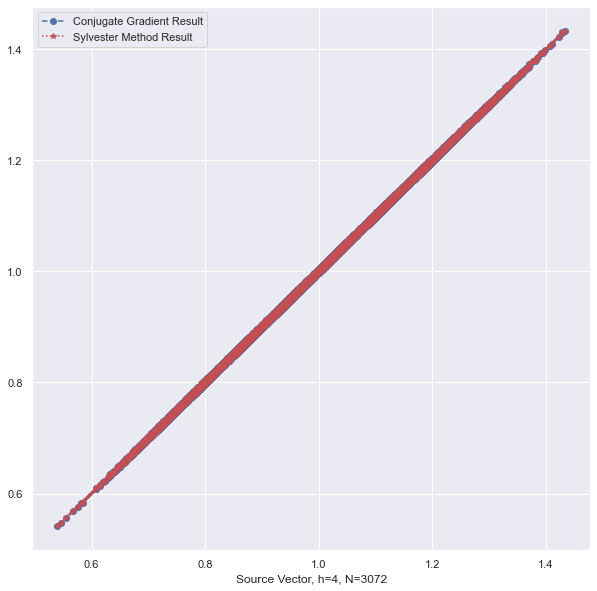

In [4]:
plt.rcParams["figure.figsize"] = (10,10)
# Plot a simple line chart
plt.errorbar(df['Source'], df['Conjugate Gradient'], color='b', label='Conjugate Gradient Result', marker='o', linestyle='dashed')

# Plot another line on the same chart/graph
plt.errorbar(df['Source'], df['Sylvester'], color='r', label='Sylvester Method Result', marker='*', linestyle='dotted')

plt.xlabel('Source Vector, h=4, N=3072')
plt.legend()
plt.show()

## Time cost

In [5]:
df_cost = pd.read_csv('time_and_memory.csv')
df_cost['N'] = df_cost.apply(lambda row: (4**int(row['level'])) * 12, axis=1)

<AxesSubplot:xlabel='N', ylabel='time'>

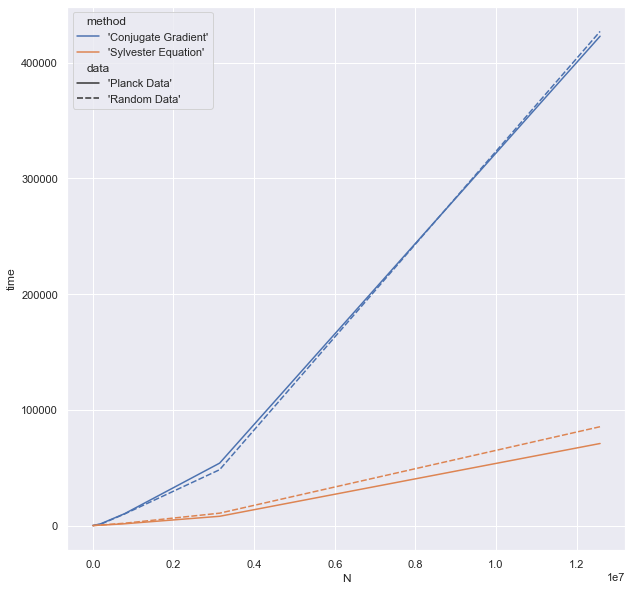

In [6]:
sns.lineplot(data=df_cost, 
             x='N', y='time', hue='method', style='data')

<AxesSubplot:xlabel='N', ylabel='memory'>

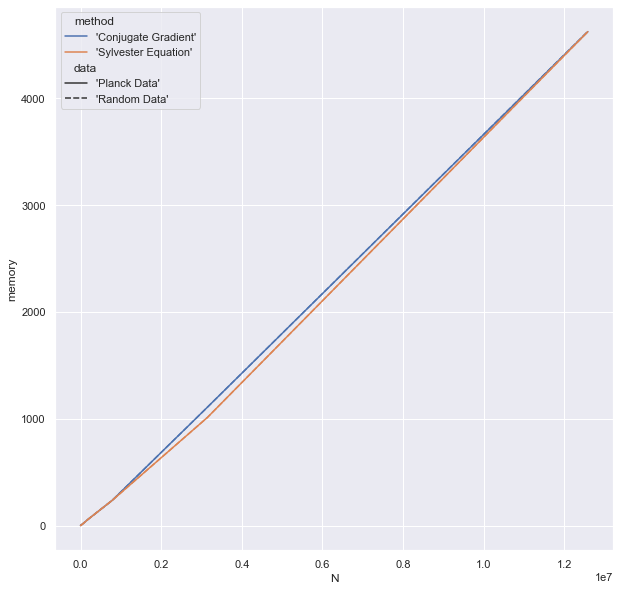

In [7]:
sns.lineplot(data=df_cost, 
             x='N', y='memory', hue='method', style='data')

## Profiling

In [8]:
def get_profiling_file(ptype, algo, level):
    profiling_folder = '../output/profiling/'
    file_name = f"{ptype}_{algo}_planck_{level}.txt"
    return profiling_folder + file_name

In [9]:
# Example of a profiling file
file_path = get_profiling_file('time', 'cg', 4)
with open(file_path) as f:
    print(f.read())

File: cmbsolution
Type: cpu
Time: Dec 15, 2021 at 3:49pm (GMT)
Duration: 210.30ms, Total samples = 180ms (85.59%)
Showing nodes accounting for 180ms, 100% of 180ms total
      flat  flat%   sum%        cum   cum%
      40ms 22.22% 22.22%       40ms 22.22%  runtime.pthread_cond_wait
      30ms 16.67% 38.89%       30ms 16.67%  runtime.usleep
      20ms 11.11% 50.00%       20ms 11.11%  runtime.kevent
      20ms 11.11% 61.11%       20ms 11.11%  runtime.pthread_cond_signal
      10ms  5.56% 66.67%       10ms  5.56%  aeshashbody
      10ms  5.56% 72.22%       10ms  5.56%  runtime.(*bmap).overflow (inline)
      10ms  5.56% 77.78%       10ms  5.56%  runtime.(*spanSet).push
      10ms  5.56% 83.33%       90ms 50.00%  runtime.findrunnable
      10ms  5.56% 88.89%       10ms  5.56%  runtime.gcWriteBarrier
      10ms  5.56% 94.44%       10ms  5.56%  runtime.madvise
      10ms  5.56%   100%       20ms 11.11%  runtime.mapassign_faststr
         0     0%   100%       40ms 22.22%  conjugate/solu.(*DX

In [10]:
df = pd.DataFrame(columns=['Type', 'Algorithm', 'Level', 'Flat', 'Flat%', 'Sum%', 'Cum', 'Cum%', 'Detail'])
for ptype in ['time', 'memory']:
    for algo in ['cg', 'syl']:
        for level in range(1, 11):
            file_path = get_profiling_file(ptype, algo, level)
            with open(file_path) as f:
                contents = f.readlines()
                for line in contents:
                    if line[0] == " " and line.strip()[0] != "f":
                        arr = line.strip().split()[:6]
                        row = [ptype, algo, level] + arr
                        df.loc[len(df)] = row
                    
print("Number of profiling instances: {}".format(df.shape[0]))
df.head()

Number of profiling instances: 1312


,Type,Algorithm,Level,Flat,Flat%,Sum%,Cum,Cum%,Detail
0,time,cg,1,10ms,50.00%,50.00%,10ms,50.00%,runtime.madvise
1,time,cg,1,10ms,50.00%,100%,10ms,50.00%,runtime.usleep
2,time,cg,1,0,0%,100%,10ms,50.00%,runtime.(*mheap).alloc.func1
3,time,cg,1,0,0%,100%,10ms,50.00%,runtime.(*mheap).allocSpan
4,time,cg,1,0,0%,100%,10ms,50.00%,runtime.findrunnable


In [11]:
# Format the numbers and percentages
def format_time(t):
    if t == "0":
        return float(0)
    else:
        if t[-2] in ['m', 'M', 'k']:
            return float(t[:-2])
        else:
            return float(t[:-1])
    
def format_percentage(p):
    return float(p[:-1])

In [12]:
df['Flat'] = df.apply(lambda row: format_time(row['Flat']), axis=1)
df['Flat%'] = df.apply(lambda row: format_percentage(row['Flat%']), axis=1)
df['Sum%'] = df.apply(lambda row: format_percentage(row['Sum%']), axis=1)
df['Cum'] = df.apply(lambda row: format_time(row['Cum']), axis=1)
df['Cum%'] = df.apply(lambda row: format_percentage(row['Cum%']), axis=1)

In [13]:
df.head()

,Type,Algorithm,Level,Flat,Flat%,Sum%,Cum,Cum%,Detail
0,time,cg,1,10.0,50.0,50.0,10.0,50.0,runtime.madvise
1,time,cg,1,10.0,50.0,100.0,10.0,50.0,runtime.usleep
2,time,cg,1,0.0,0.0,100.0,10.0,50.0,runtime.(*mheap).alloc.func1
3,time,cg,1,0.0,0.0,100.0,10.0,50.0,runtime.(*mheap).allocSpan
4,time,cg,1,0.0,0.0,100.0,10.0,50.0,runtime.findrunnable


### Conjugate Gradient

In [24]:
# Filter the dataframe: Conjugate Gradient time, the first few levels are ignored because the time is too small
# We also ignored functions that contributed insignificantly to the total runtime
# System functions are also filtered out.
df_cg_time = df[(df['Type'] == 'time') & (df['Algorithm'] == 'cg') & (df['Level'] >= 4) \
                & (df['Flat%'] > 0) & (df['Detail'].str.startswith('conjugate'))]
df_cg_time.sort_values(by=['Flat%'], ascending=False)

,Type,Algorithm,Level,Flat,Flat%,Sum%,Cum,Cum%,Detail
408,time,cg,9,67.26,27.24,61.28,224.46,90.91,conjugate/solu.(*DXOpe).cal
458,time,cg,10,314.34,26.60,56.49,1028.86,87.06,conjugate/solu.(*DXOpe).cal
344,time,cg,8,10.62,21.90,56.65,39.62,81.71,conjugate/solu.(*DXOpe).cal
272,time,cg,7,1.08,15.91,65.10,3.40,50.07,conjugate/solu.(*DXOpe).cal
154,time,cg,6,0.13,6.81,58.64,1.04,54.45,conjugate/solu.(*DXOpe).cal
461,time,cg,10,41.77,3.53,79.97,41.82,3.54,conjugate/solu.(*DXOpe).getX
95,time,cg,5,10.00,2.13,87.23,140.00,29.79,conjugate/solu.(*DXOpe).cal
96,time,cg,5,10.00,2.13,89.36,10.00,2.13,conjugate/solu.(*DXOpe).setR
411,time,cg,9,4.70,1.90,83.50,4.71,1.91,conjugate/solu.(*DXOpe).getX
278,time,cg,7,0.11,1.62,84.98,0.16,2.36,conjugate/solu.(*VMatrix).At


In [25]:
df_cg_time['Detail'].value_counts()

conjugate/solu.(*DXOpe).cal     6
conjugate/solu.(*DXOpe).setR    5
conjugate/solu.(*DXOpe).getX    5
conjugate/solu.(*VMatrix).At    5
conjugate/solu.findNeighbors    5
Name: Detail, dtype: int64

In [73]:
df_time = df[df['Type'] == 'time']
top3_commands = ['conjugate/solu.(*DXOpe).cal', 'conjugate/solu.(*IteSolu).calBtCBx', 'conjugate/solu.findNeighbors']
df_cg_time = df_time[(df_time['Algorithm'] == 'cg') & (df['Detail'].isin(top3_commands)) & (df['Level'] >= 4)]

Text(0, 0.5, 'Percentage of time')

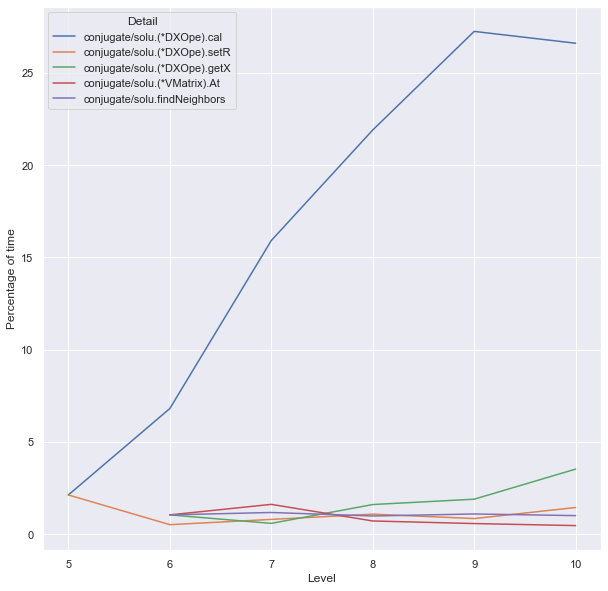

In [26]:
sns.lineplot(data=df_cg_time, x='Level', y='Flat%', hue='Detail')
plt.ylabel("Percentage of time")

In [30]:
df_cg_mem = df[(df['Type'] == 'memory') & (df['Algorithm'] == 'cg') & (df['Level'] >= 6) \
                & (df['Detail'].str.startswith('conjugate'))]
df_cg_mem.sort_values(by=['Cum%'], ascending=False)

,Type,Algorithm,Level,Flat,Flat%,Sum%,Cum,Cum%,Detail
1142,memory,cg,7,0.0,0.0,100.00,18.02,47.22,conjugate/utils.LoadY
1183,memory,cg,10,0.0,0.0,100.00,1039.25,44.09,conjugate/utils.LoadY
1153,memory,cg,8,0.0,0.0,99.65,60.83,42.74,conjugate/utils.LoadY
1127,memory,cg,6,0.0,0.0,100.00,3650.94,38.71,conjugate/utils.LoadY
1164,memory,cg,9,0.0,0.0,100.00,307.93,36.31,conjugate/utils.LoadY
1126,memory,cg,6,0.0,0.0,100.00,1616.48,17.14,conjugate/solu.(*IteSolu).FindSolution
1152,memory,cg,8,0.0,0.0,99.65,24.00,16.86,conjugate/solu.(*IteSolu).FindSolution
1182,memory,cg,10,0.0,0.0,100.00,384.00,16.29,conjugate/solu.(*IteSolu).FindSolution
1141,memory,cg,7,0.0,0.0,100.00,6.00,15.72,conjugate/solu.(*IteSolu).FindSolution
1163,memory,cg,9,0.0,0.0,100.00,96.00,11.32,conjugate/solu.(*IteSolu).FindSolution


Text(0, 0.5, 'Percentage of memory')

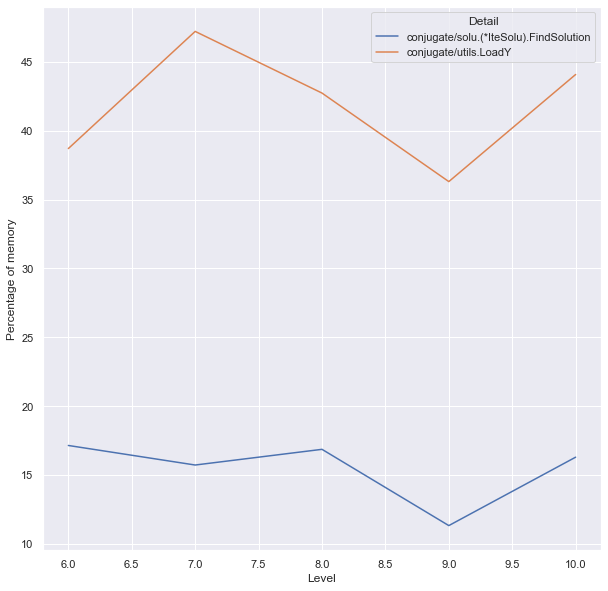

In [31]:
sns.lineplot(data=df_cg_mem, x='Level', y='Cum%', hue='Detail')
plt.ylabel("Percentage of memory")

### Sylvester Method

In [33]:
df_syl_time = df[(df['Type'] == 'time') & (df['Algorithm'] == 'syl') & (df['Level'] >= 4) \
                & (df['Flat%'] > 0) & (df['Detail'].str.startswith('conjugate'))]
df_syl_time.sort_values(by=['Flat%'], ascending=False).head()

,Type,Algorithm,Level,Flat,Flat%,Sum%,Cum,Cum%,Detail
1013,time,syl,10,46.26,17.43,42.23,207.23,78.08,conjugate/solu.(*DXOpe).cal
927,time,syl,9,7.36,17.21,39.24,32.19,75.28,conjugate/solu.(*DXOpe).cal
841,time,syl,8,0.77,10.59,57.91,4.17,57.36,conjugate/solu.(*DXOpe).cal
1015,time,syl,10,20.85,7.86,65.60,103.97,39.17,conjugate/solu.findNeighbors
929,time,syl,9,2.18,5.10,61.53,14.01,32.76,conjugate/solu.findNeighbors


In [34]:
df_syl_time.Detail.value_counts()

conjugate/solu.(*DXOpe).cal     5
conjugate/solu.findNeighbors    5
conjugate/solu.VectorMul        4
conjugate/solu.(*DXOpe).getX    3
conjugate/solu.NewSylSolu       3
conjugate/solu.ReducedQR        3
conjugate/solu.(*VMatrix).At    2
conjugate/solu.(*DXOpe).setR    1
Name: Detail, dtype: int64

Text(0, 0.5, 'Percentage of time')

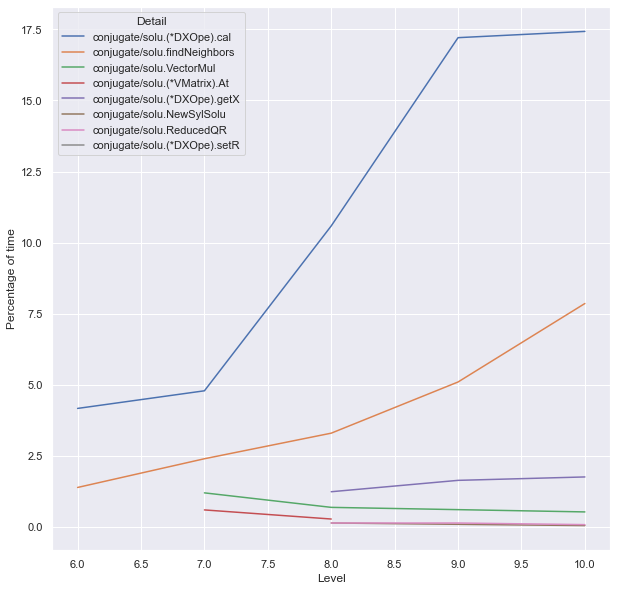

In [37]:
sns.lineplot(data=df_syl_time, x='Level', y='Flat%', hue='Detail')
plt.ylabel("Percentage of time")

In [41]:
df_syl_mem = df[(df['Type'] == 'memory') & (df['Algorithm'] == 'syl') & (df['Level'] >= 4) \
                 & (df['Detail'].str.startswith('conjugate'))]
df_syl_mem.sort_values(by=['Flat%'], ascending=False).head()

,Type,Algorithm,Level,Flat,Flat%,Sum%,Cum,Cum%,Detail
1236,memory,syl,5,727.78,32.42,100.00,727.78,32.42,conjugate/solu.NewSylSolu
1248,memory,syl,6,1.58,18.14,100.00,1.58,18.14,conjugate/solu.NewSylSolu
1268,memory,syl,8,24.00,16.86,99.65,24.00,16.86,conjugate/solu.NewSylSolu
1258,memory,syl,7,6.00,15.72,100.00,6.00,15.72,conjugate/solu.NewSylSolu
1296,memory,syl,10,384.00,12.32,100.00,384.00,12.32,conjugate/solu.NewSylSolu


Text(0, 0.5, 'Percentage of memory')

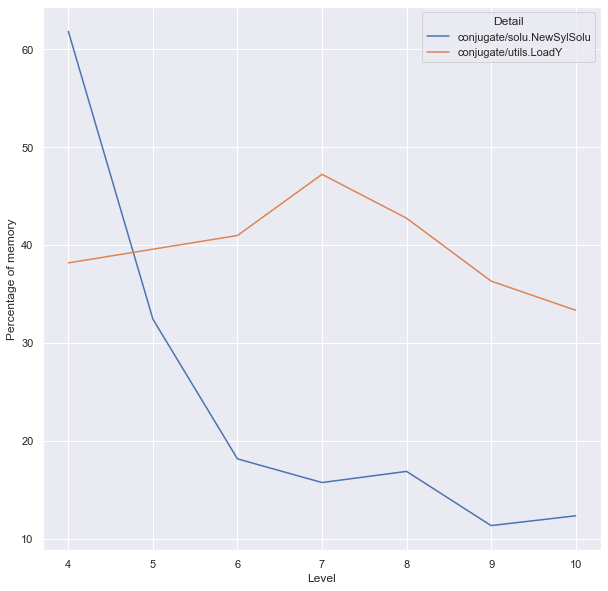

In [44]:
sns.lineplot(data=df_syl_mem, x='Level', y='Cum%', hue='Detail')
plt.ylabel("Percentage of memory")